In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(0, 1),
    ]
)

# Load the training and test datasets
train_data = datasets.MNIST("data", train=True, download=True, transform=transform)
test_data = datasets.MNIST("data", train=False, download=True, transform=transform)

# Create data loaders to load the data in batches
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

X_train = train_data.data.float().unsqueeze(1)
X_test = test_data.data.float().unsqueeze(1)

# binarize
X_train[X_train > 0] = 1
X_test[X_test > 0] = 1

X_train.shape, X_test.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([10000, 1, 28, 28]))

In [2]:
# Adapted from https://discuss.pytorch.org/t/unet-implementation/426

import torch
from torch import nn
import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=2,
        depth=4,
        wf=4,
        padding=True,
        batch_norm=True,
        up_mode="upconv",
        device="cuda",
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597

        Using the default arguments will yield the exact version used
        in the original paper

        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ("upconv", "upsample")
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

        self.device = device
        self.to(device)

    def forward(self, x):
        x = x.to(self.device)
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == "upconv":
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == "upsample":
            self.up = nn.Sequential(
                nn.Upsample(mode="bilinear", scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

In [3]:
model = UNet(
    in_channels=1,
    n_classes=2,
    depth=3,
    padding=True,
    wf=2,
)

batch = X_train[:64].to("cuda")
model(batch).shape, sum((p.numel() for p in model.parameters()))

(torch.Size([64, 2, 28, 28]), 7562)

In [4]:
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm.notebook import tqdm
import torch.optim.lr_scheduler as lr_scheduler

batch_size = 8192
num_epochs = 100
optimizer = AdamW(model.parameters(), lr=0.1)

scheduler = lr_scheduler.ExponentialLR(
    optimizer,
    gamma=0.99,
)
loss_fn = F.cross_entropy

for epoch in tqdm(range(num_epochs)):
    # get into training mode
    model.train()
    losses = []
    for batch_num in range(X_train.shape[0] // batch_size):
        optimizer.zero_grad()

        # initialize proper `x`
        ix = torch.randint(0, X_train.shape[0], size=(batch_size,))
        x = X_train[ix]  # true values

        # predict demasked tokens
        x_pred = model(x)
        loss = loss_fn(x_pred, x.squeeze(1).long().to("cuda"))

        # do backprop
        losses.append(loss.item())
        loss.backward()
    optimizer.step()
    scheduler.step()

    # validation mode
    model.eval()
    with torch.no_grad():
        ix_test = torch.randint(0, X_test.shape[0], (batch_size,))
        x_test = X_test[ix_test].to("cuda")

        x_pred_test = model(x_test)
        test_loss = loss_fn(x_pred_test, x_test.squeeze(1).long().to("cuda"))

        print(
            f"{epoch=}, train_loss={torch.tensor(losses).mean().item():2.4f}, val_loss={test_loss.item():2.4f}"
        )
    break

  0%|          | 0/100 [00:00<?, ?it/s]

/home/marinegor/github/toponym_diffusion/.venv/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch=0, train_loss=0.6878, val_loss=0.5818


In [5]:
import matplotlib.pyplot as plt


def plot_image_grid(images):
    num_images = len(images)
    rows = 10
    cols = 10

    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))

    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            if index < num_images:
                axes[i, j].imshow(images[index])
                axes[i, j].axis("off")
            else:
                axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()

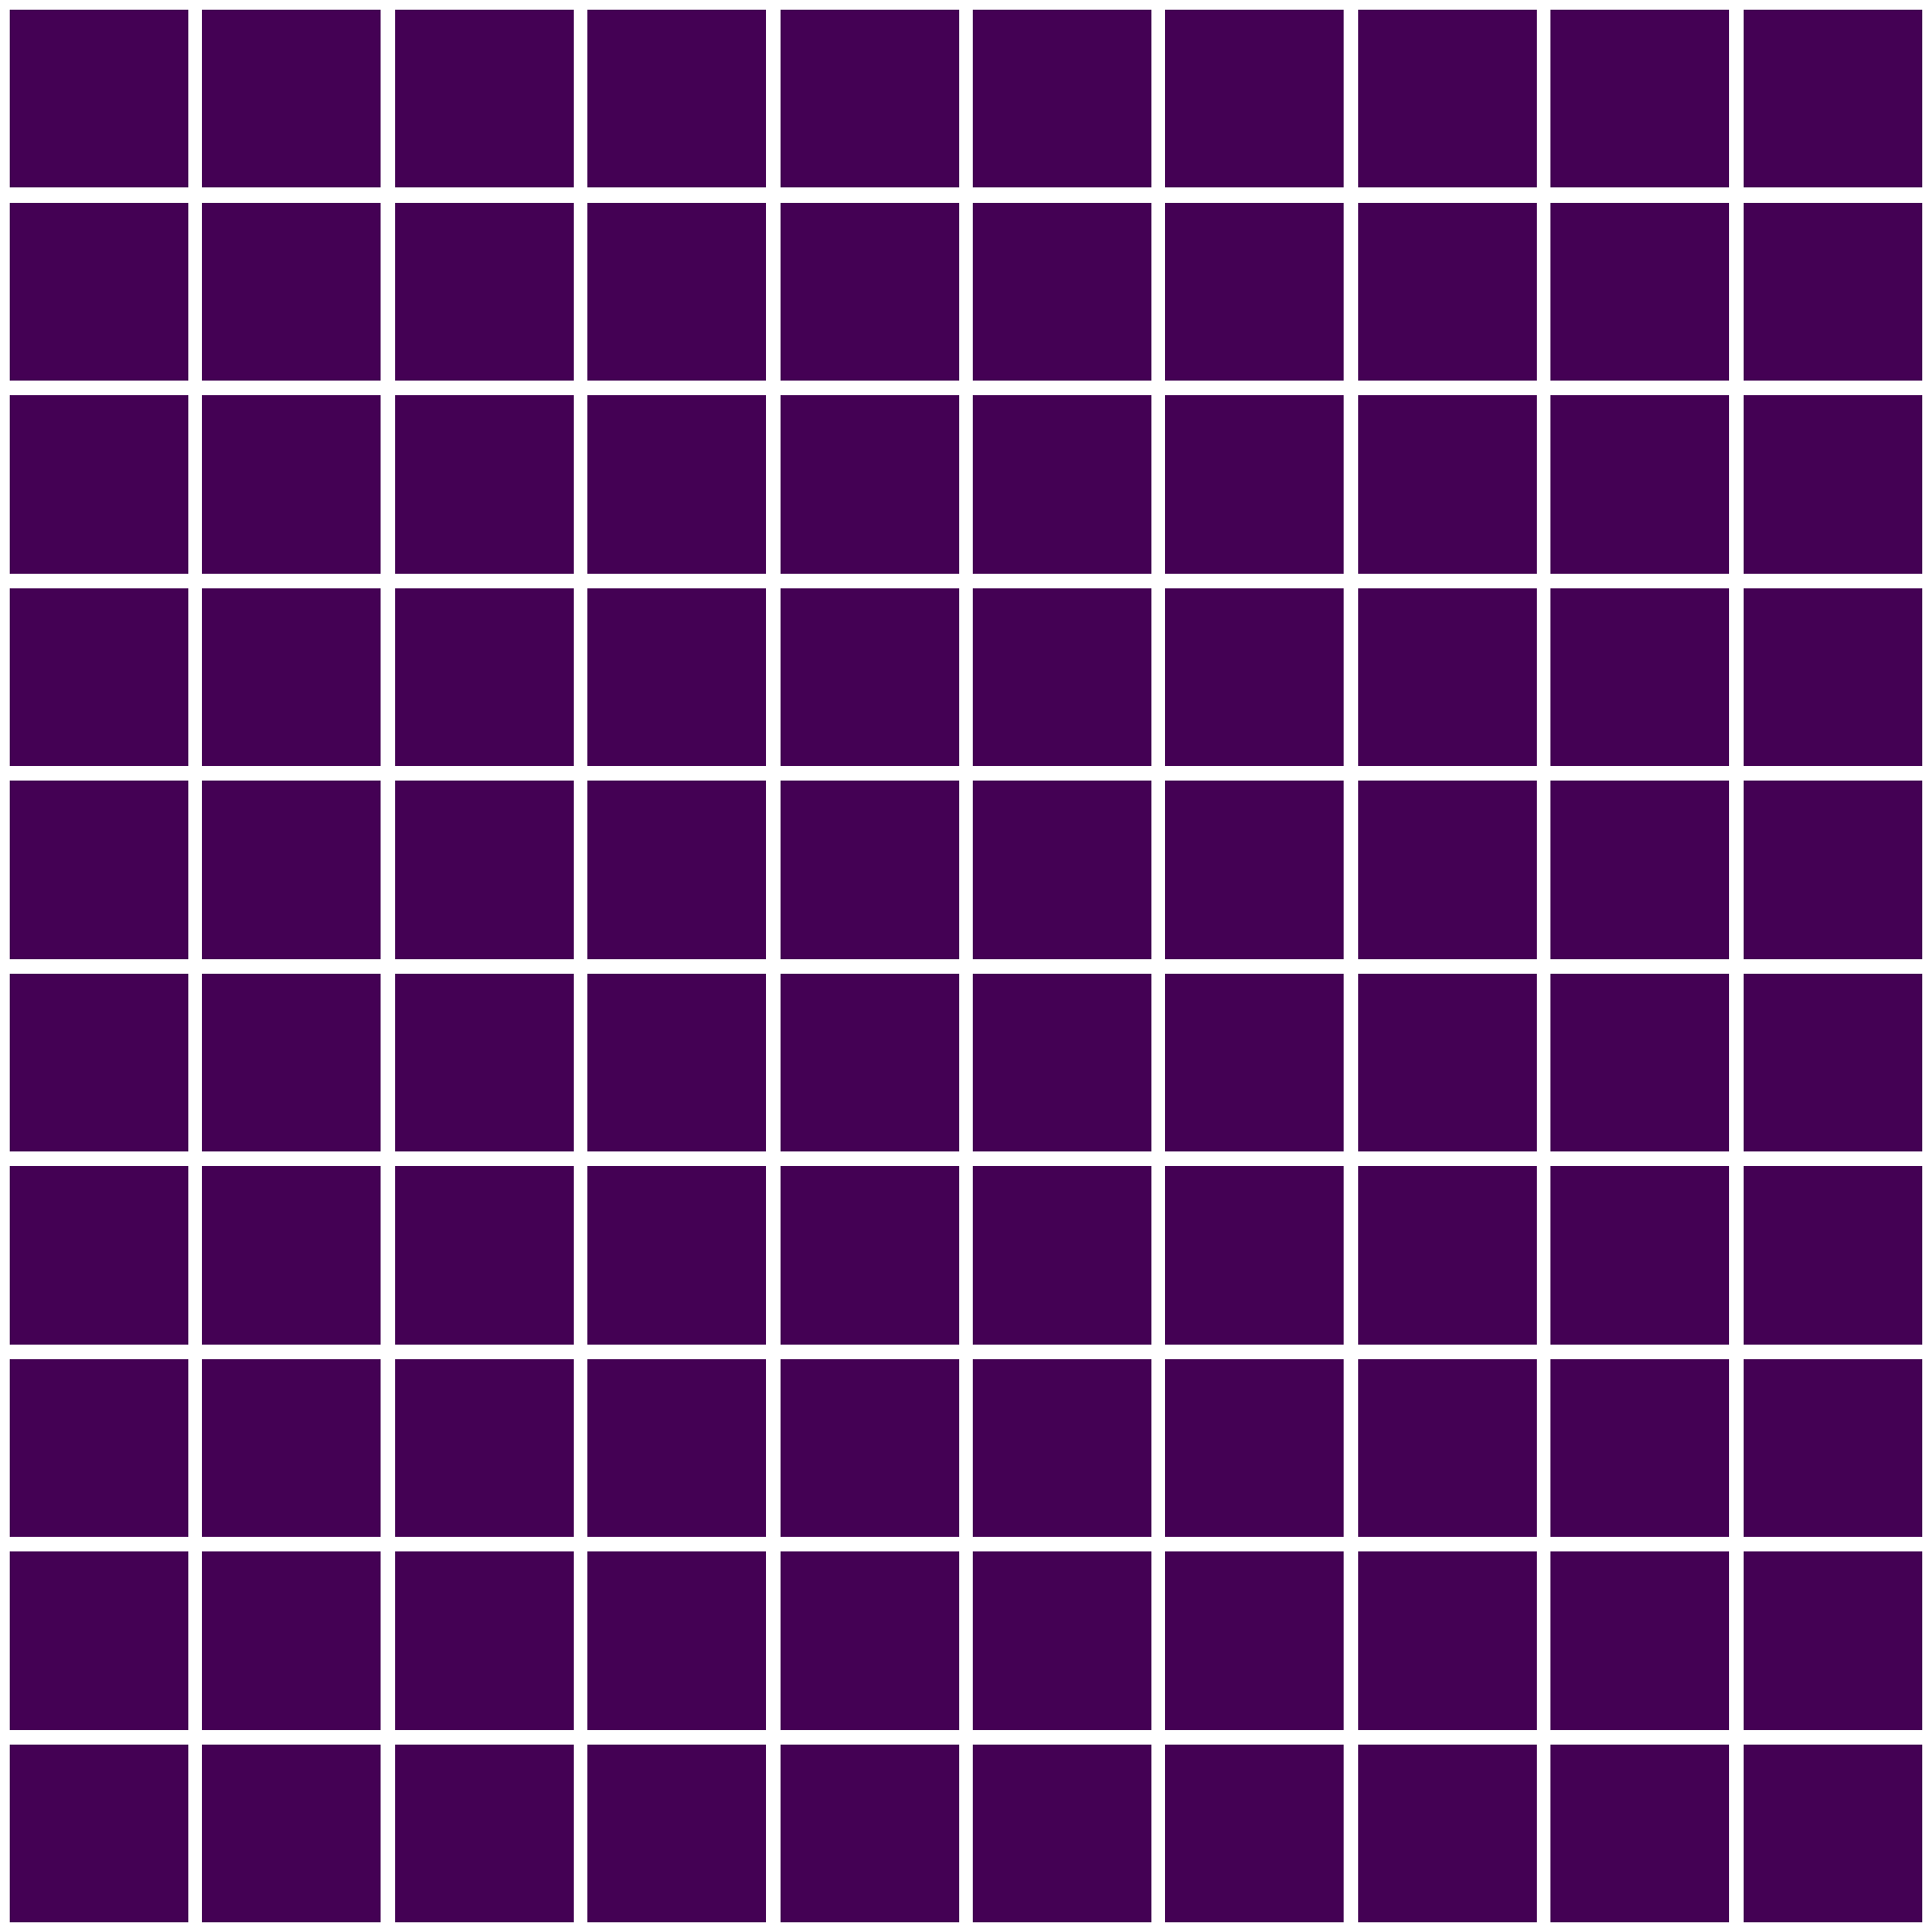

In [6]:
model.eval()

test_batch = X_test[:100]
preds = model(test_batch).argmax(1).squeeze(1).to("cpu").detach().numpy()

plot_image_grid(preds)

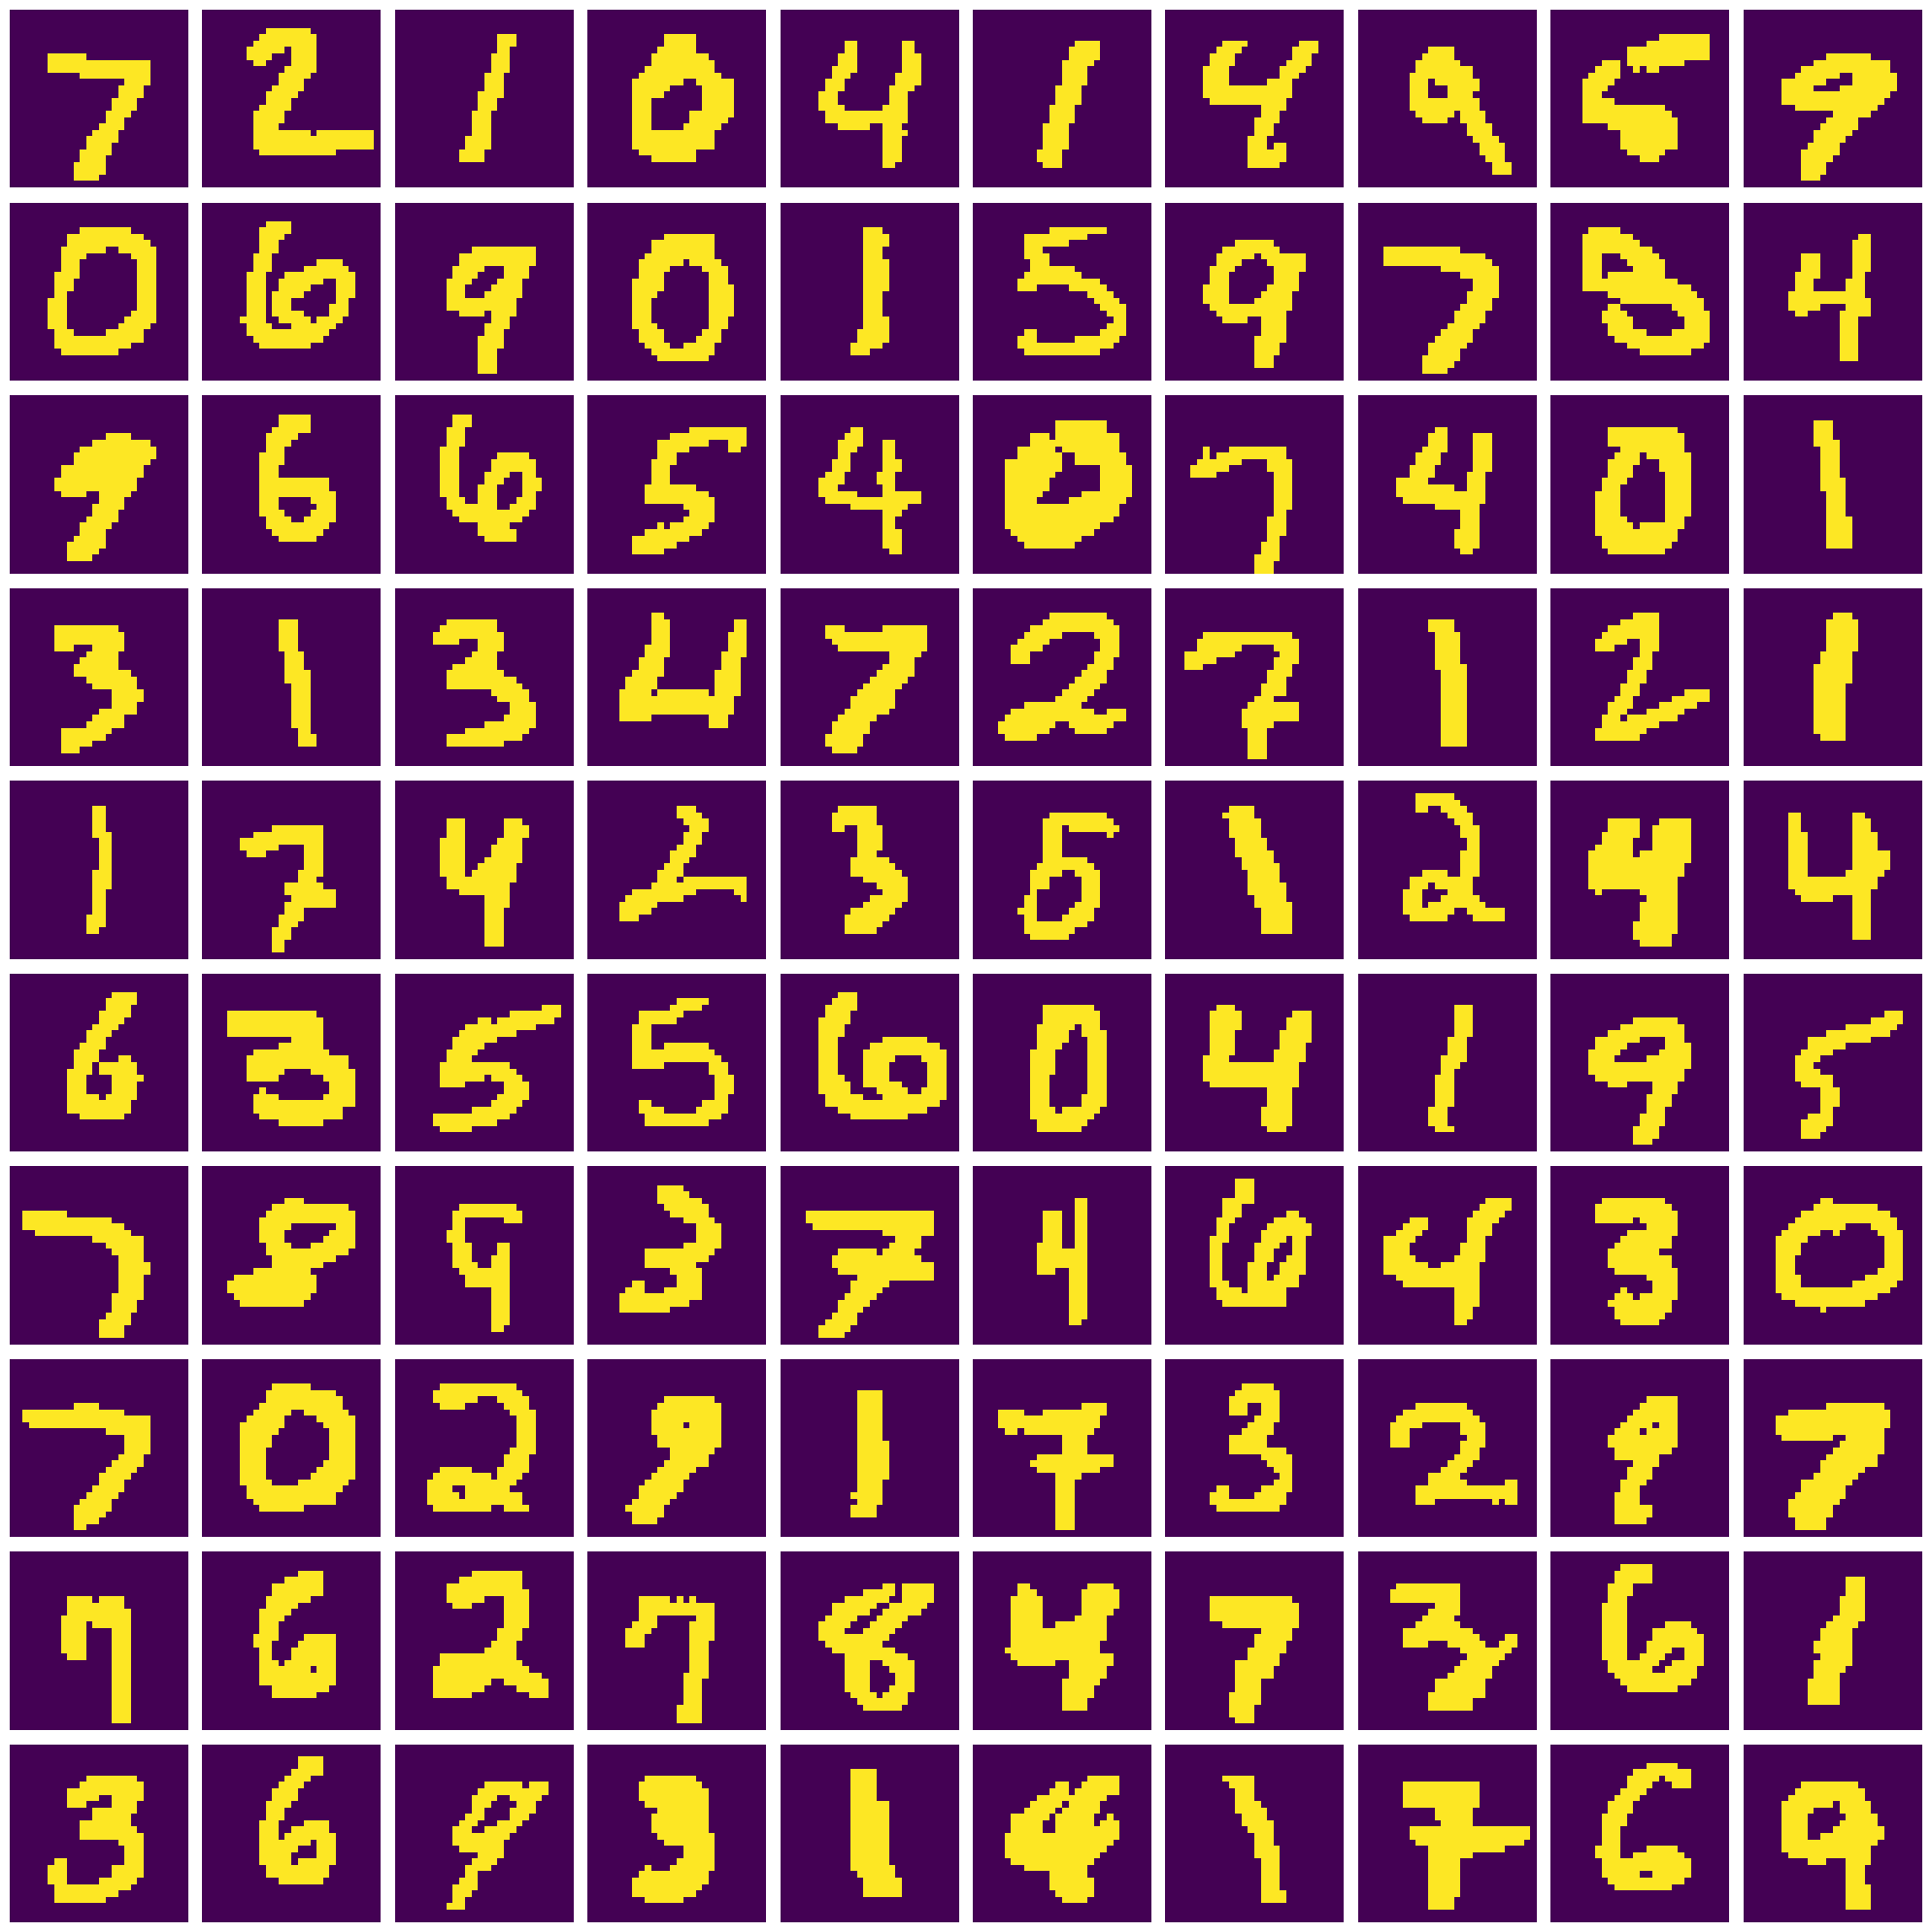

In [7]:
origs = test_batch.squeeze(1).to("cpu").detach().numpy()
plot_image_grid(origs)

# Diffusion

In [8]:
class ForwardProcess:
    def __init__(self, betas: torch.Tensor):
        self.beta = betas

        self.alphas = 1.0 - betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=-1)

    def get_x_t(
        self, x_0: torch.Tensor, t: torch.LongTensor
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """Forward diffusion process given the unperturbed sample x_0.

        Args:
            x_0: Original, unperturbed samples.
            t: Target timestamp of the diffusion process of each sample.

        Returns:
            Noise added to original sample and perturbed sample.
        """
        eps_0 = torch.randn_like(x_0).to(x_0)
        alpha_bar = self.alpha_bar[t, None]
        mean = (alpha_bar**0.5) * x_0
        std = (1.0 - alpha_bar) ** 0.5

        return (eps_0, mean + std * eps_0)


class ReverseProcess(ForwardProcess):
    def __init__(self, betas: torch.Tensor, model: nn.Module):
        super().__init__(betas)
        self.model = model
        self.T = len(betas) - 1

        self.sigma = (
            (1 - self.alphas)
            * (1 - torch.roll(self.alpha_bar, 1))
            / (1 - self.alpha_bar)
        ) ** 0.5
        self.sigma[1] = 0.0

    def get_x_t_minus_one(self, x_t: torch.Tensor, t: int) -> torch.Tensor:
        with torch.no_grad():
            t_vector = torch.full(size=(len(x_t),), fill_value=t, dtype=torch.long)
            eps = self.model(x_t, t=t_vector)

        eps *= (1 - self.alphas[t]) / ((1 - self.alpha_bar[t]) ** 0.5)
        mean = 1 / (self.alphas[t] ** 0.5) * (x_t - eps)
        return mean + self.sigma[t] * torch.randn_like(x_t)

    def sample(self, n_samples=1, full_trajectory=False):
        # Initialize with X_T ~ N(0, I)
        x_t = torch.randn(n_samples, 2)
        trajectory = [x_t.clone()]

        for t in range(self.T, 0, -1):
            x_t = self.get_x_t_minus_one(x_t, t=t)

            if full_trajectory:
                trajectory.append(x_t.clone())
        return torch.stack(trajectory, dim=0) if full_trajectory else x_t

In [9]:
T = 100  # Number of diffusion steps
betas = torch.linspace(0.0, 0.99, T + 1) ** 4
betas = betas.flatten()
fp = ForwardProcess(betas=betas)

In [10]:
x = X_train[:100].clone()

In [11]:
import numpy as np
from tqdm.notebook import tqdm

xt = []
for idx, t in tqdm(enumerate(range(T))):
    x_t = (
        fp.get_x_t(x.reshape(100, -1), t=torch.LongTensor([t] * 100))[1]
        .numpy()
        .reshape(100, 1, 28, 28)
    )
    xt.append(x_t)
xt = np.hstack(xt)
xt.shape

0it [00:00, ?it/s]

(100, 100, 28, 28)

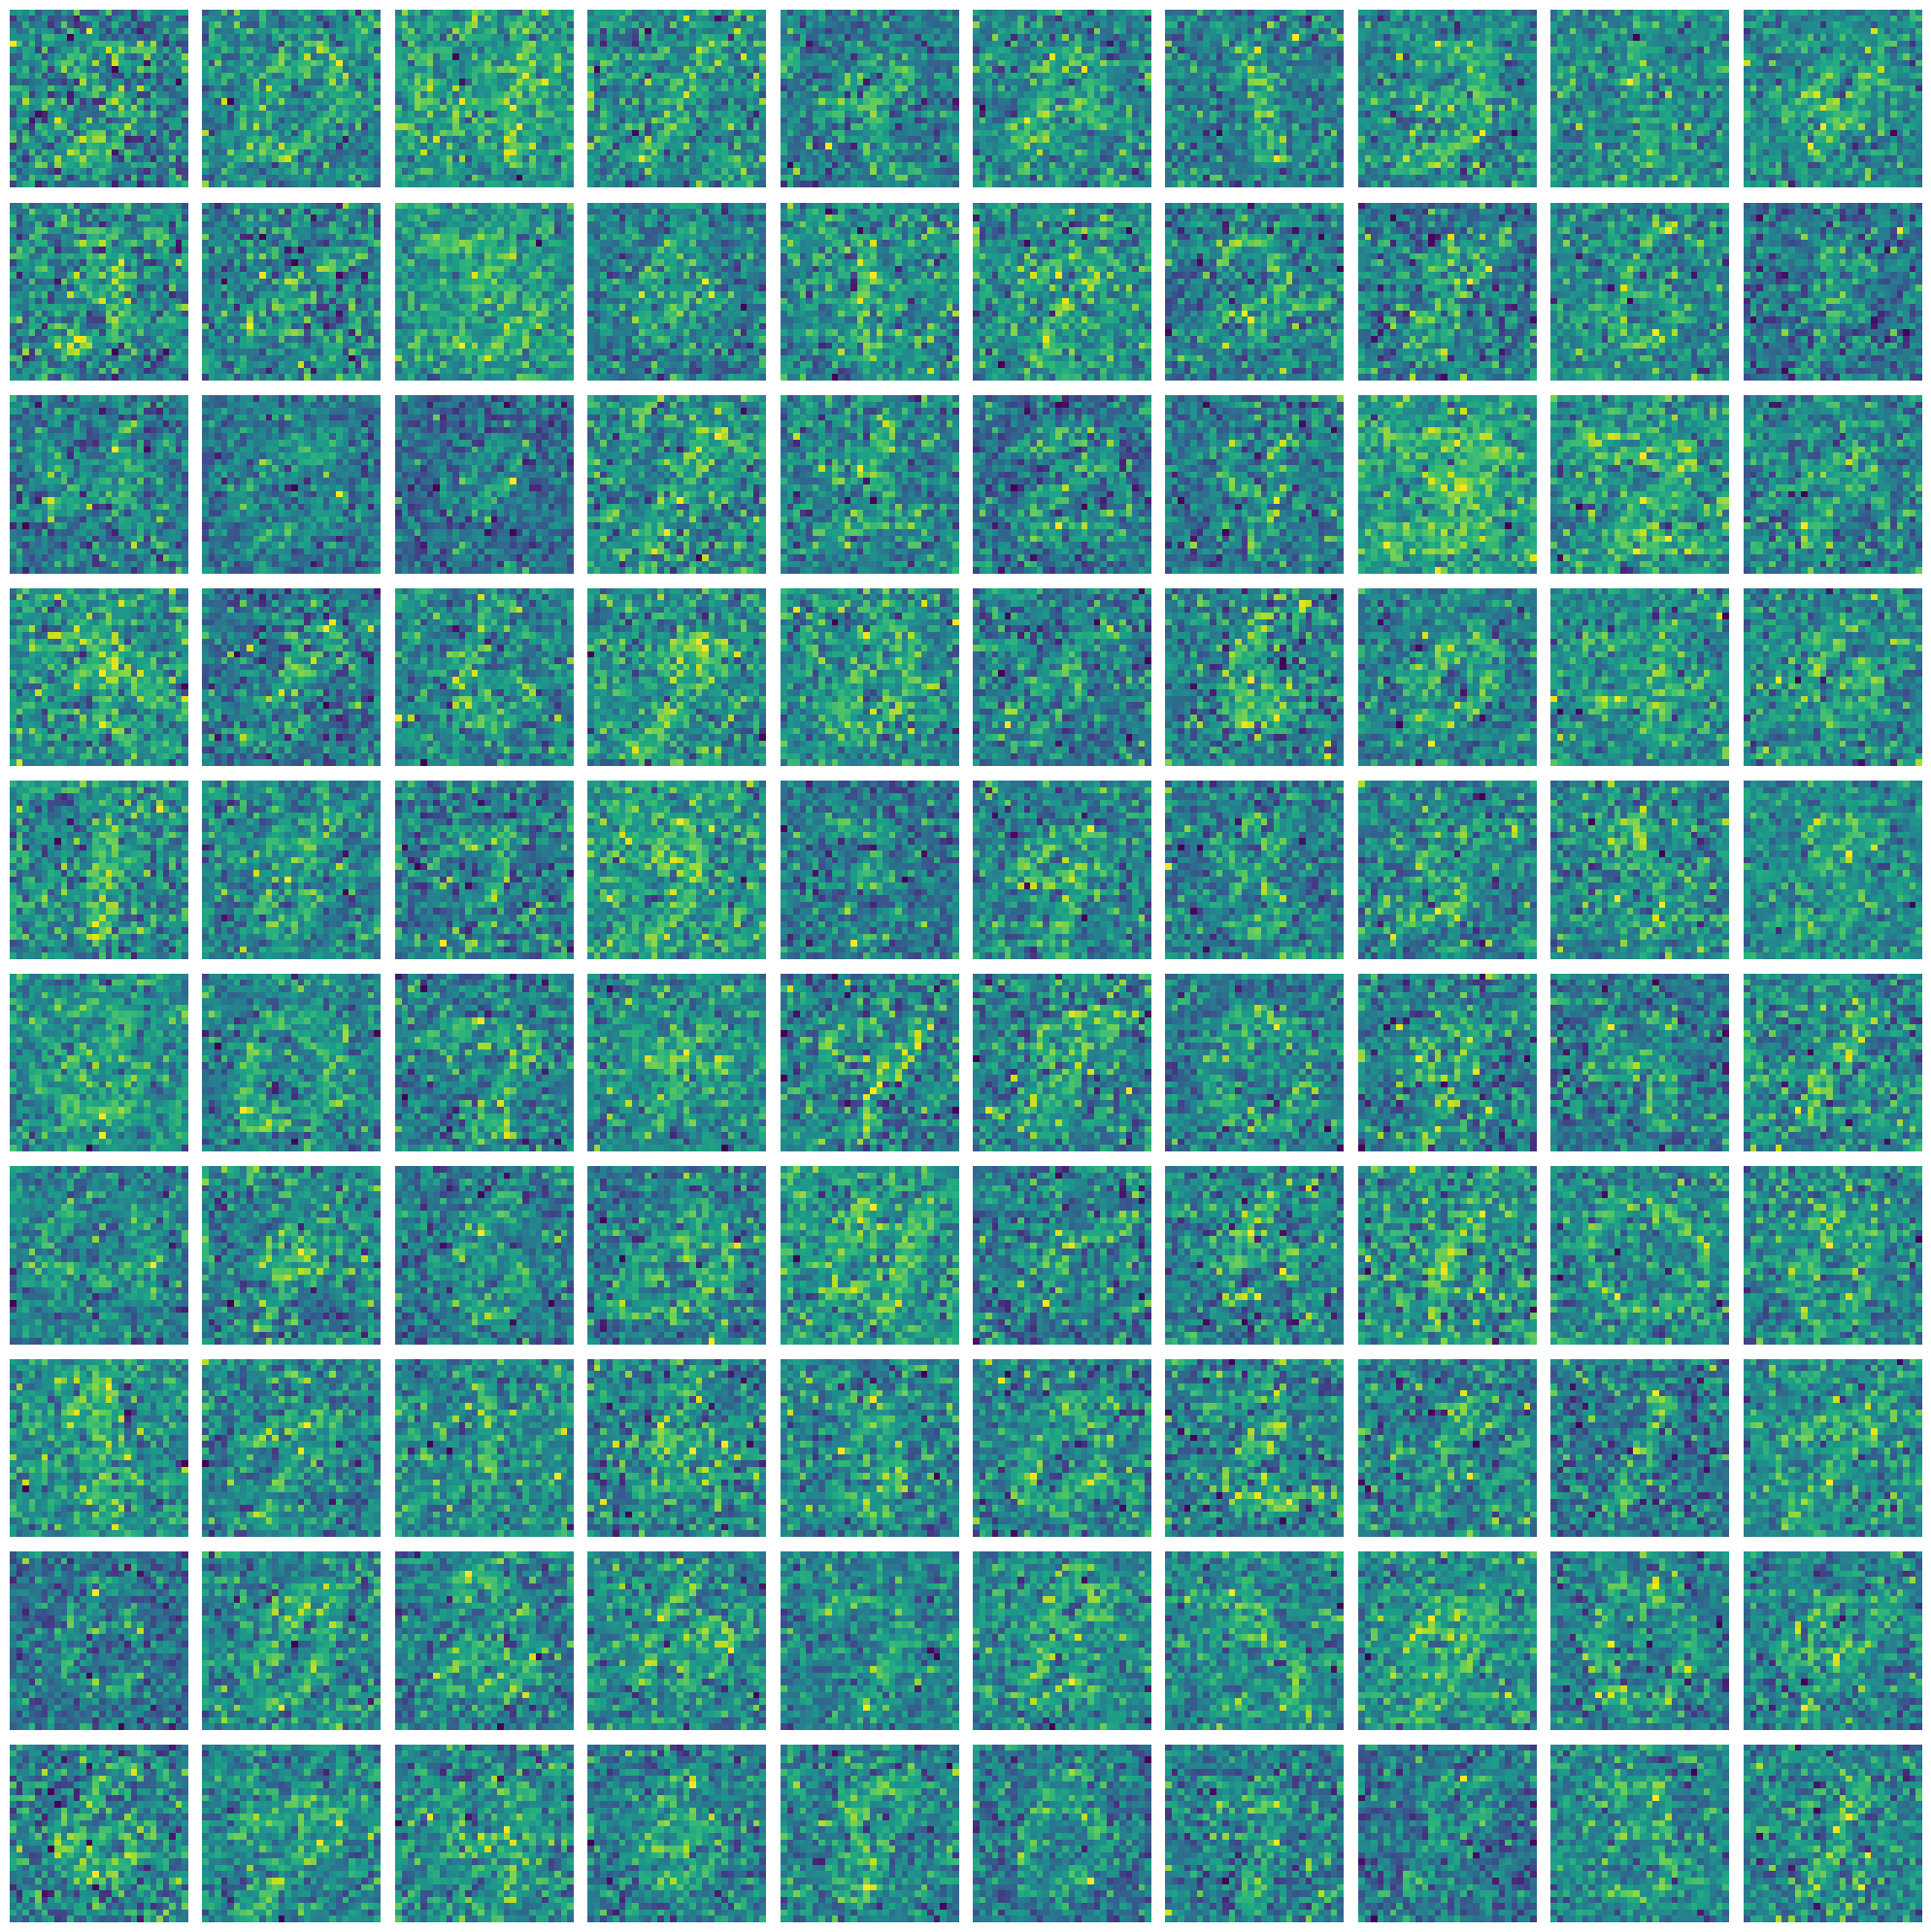

In [12]:
plot_image_grid(xt[:, 50, :])

In [49]:
# Adapted from https://discuss.pytorch.org/t/unet-implementation/426

import torch
from torch import nn
import torch.nn.functional as F
from torchtyping import TensorType as TT
import math


def positional_embeding_matrix(
    position_id: int, d_out: int
) -> TT["position_id", "out_dim"]:  # noqa: F821
    """Generates a pre-computed tensor with positional embeddings.

    Returns
    -------
    torch.Tensor
        embedings tensor; `i` position contains vector for `if token is at position "i"`
    """
    assert d_out % 2 == 0, f"d_out should be even, got {d_out=}"

    position: TT["position_id", 1] = torch.arange(position_id).unsqueeze(-1)
    div_term: TT["d_out // 2"] = (
        torch.arange(0, d_out, 2) * (-math.log(10_000.0) / d_out)
    ).exp()
    pe = torch.zeros(position_id, d_out)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe


class PositionalEmbedder(nn.Module):
    def __init__(self, num_possible_tokens: int, d_embed: int):
        super().__init__()
        self.num_possible_tokens = num_possible_tokens
        self.d_embed = d_embed
        emb: TT["num_possible_tokens", "d_embed"] = positional_embeding_matrix(
            num_possible_tokens, d_embed
        )
        self.register_buffer("emb", emb)

    def forward(
        self, tokens: TT["b", "l", torch.long]
    ) -> TT["b", "l", "self.d_embed", torch.float]:  # noqa: F821
        return self.emb[tokens]


class UNetWithTime(nn.Module):
    def __init__(
        self,
        max_T=100,
        in_channels=1,
        n_classes=2,
        depth=4,
        wf=4,
        padding=True,
        batch_norm=True,
        up_mode="upconv",
        device="cuda",
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597

        Using the default arguments will yield the exact version used
        in the original paper

        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super().__init__()
        assert up_mode in ("upconv", "upsample")
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

        self.te = PositionalEmbedder(max_T, 28 * 28)
        self.device = device
        self.to(device)

    def forward(self, x, t):
        te = 0.1*self.te(t).to(self.device).reshape(-1, 28, 28).unsqueeze(1)
        x = x.to(self.device)
        x += te
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == "upconv":
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == "upsample":
            self.up = nn.Sequential(
                nn.Upsample(mode="bilinear", scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

In [50]:
T = 50  # Number of diffusion steps
betas = torch.linspace(0.0, 0.99, T + 1) ** 4
fp = ForwardProcess(betas=betas)

model = UNetWithTime(in_channels=1, n_classes=1, depth=3, padding=True, wf=4, max_T=T)

batch = X_train[:64].to("cuda")
t = torch.randint(0, T, size=(64,))
model(batch, t).shape, sum((p.numel() for p in model.parameters()))

(torch.Size([64, 1, 28, 28]), 117393)

In [51]:
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm.notebook import tqdm
import torch.optim.lr_scheduler as lr_scheduler

batch_size = 512
num_epochs = 200
optimizer = AdamW(model.parameters(), lr=0.1)


scheduler = lr_scheduler.ExponentialLR(
    optimizer,
    gamma=0.99,
)
loss_fn = F.mse_loss

for epoch in tqdm(range(num_epochs)):
    # get into training mode
    model.train()
    losses = []
    for batch_num in range(X_train.shape[0] // batch_size):
        optimizer.zero_grad()

        # initialize proper `x`
        ix = torch.randint(0, X_train.shape[0], size=(batch_size,))
        t = torch.randint(low=0, high=T, size=(batch_size,))
        x = X_train[ix]  # true values
        eps, x_t = fp.get_x_t(x.reshape(batch_size, -1), t)
        eps = eps.reshape(batch_size, 1, 28, 28)
        x_t = x_t.reshape(batch_size, 1, 28, 28)

        # Predict the noise added to x_0 from x_t
        eps_pred = model(x_t, t).to("cuda")

        # predict demasked tokens
        loss = loss_fn(eps_pred, eps.to("cuda")).to("cuda")

        # do backprop
        losses.append(loss.item())
        loss.backward()
    optimizer.step()
    scheduler.step()

    # validation mode
    model.eval()
    with torch.no_grad():
        # initialize proper `x`
        test_ix = torch.randint(0, X_test.shape[0], size=(batch_size,))
        test_t = torch.randint(low=0, high=T, size=(batch_size,))
        test_x = X_test[test_ix]  # true values
        test_eps, test_x_t = fp.get_x_t(test_x.reshape(batch_size, -1), test_t)
        test_eps = test_eps.reshape(batch_size, 1, 28, 28)
        test_x_t = test_x_t.reshape(batch_size, 1, 28, 28)

        # Predict the noise added to x_0 from x_t
        eps_pred = model(test_x_t, test_t).to("cuda")

        # predict demasked tokens
        test_loss = loss_fn(eps_pred, eps.to("cuda")).to("cuda")

        print(
            f"{epoch=}, train_loss={torch.tensor(losses).mean().item():2.4f}, val_loss={test_loss.item():2.4f}"
        )

  0%|          | 0/200 [00:00<?, ?it/s]

epoch=0, train_loss=1.1173, val_loss=1760257315438592.0000
epoch=1, train_loss=2.1250, val_loss=53418588.0000
epoch=2, train_loss=0.8917, val_loss=102.3235
epoch=3, train_loss=1.1000, val_loss=3.3636
epoch=4, train_loss=1.0255, val_loss=1.3081
epoch=5, train_loss=0.9590, val_loss=1.3220
epoch=6, train_loss=0.9466, val_loss=1.3338
epoch=7, train_loss=0.9516, val_loss=1.1302
epoch=8, train_loss=0.9623, val_loss=1.1387
epoch=9, train_loss=0.8828, val_loss=1.0863
epoch=10, train_loss=0.8507, val_loss=1.0824
epoch=11, train_loss=0.8031, val_loss=1.1913
epoch=12, train_loss=0.7782, val_loss=1.1901
epoch=13, train_loss=0.7136, val_loss=1.3038
epoch=14, train_loss=0.6527, val_loss=1.3900
epoch=15, train_loss=0.6146, val_loss=1.5333
epoch=16, train_loss=0.5852, val_loss=1.6467
epoch=17, train_loss=0.5592, val_loss=1.7315
epoch=18, train_loss=0.5455, val_loss=1.8243
epoch=19, train_loss=0.5464, val_loss=1.7928
epoch=20, train_loss=0.5291, val_loss=1.8430
epoch=21, train_loss=0.5141, val_loss=1.7

KeyboardInterrupt: 

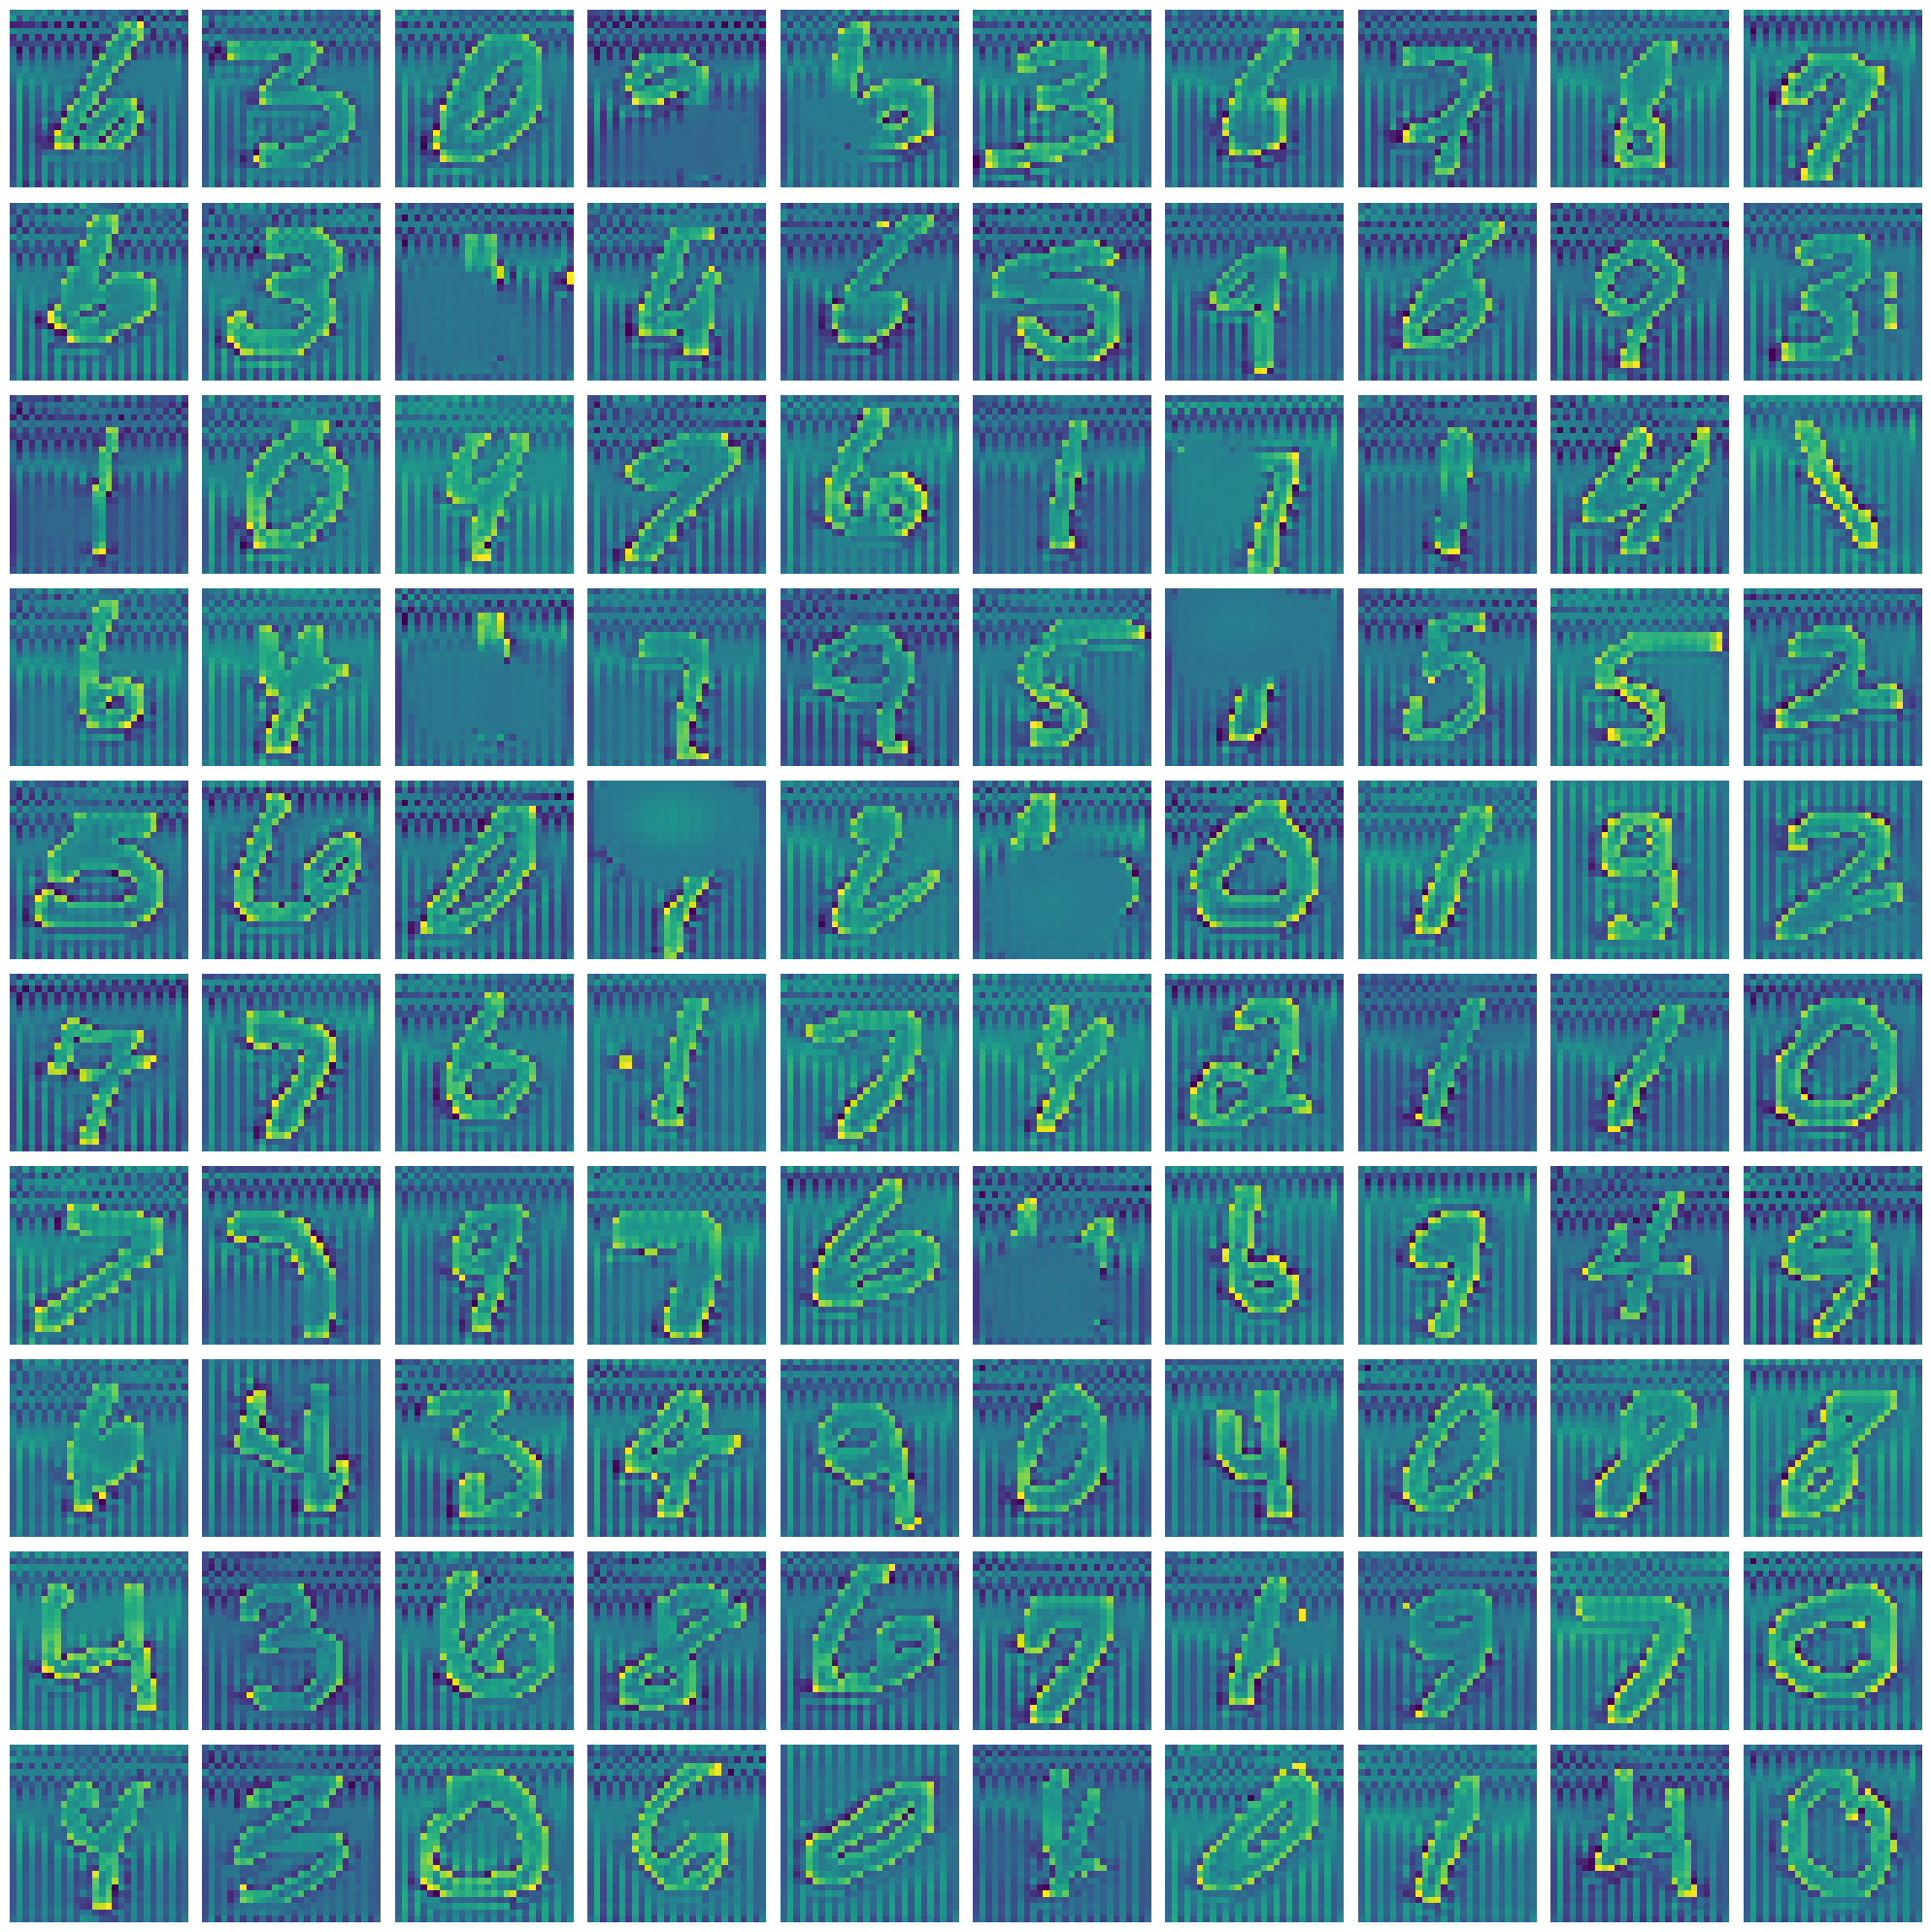

In [52]:
plot_image_grid(model(x, t).squeeze(1).to('cpu').detach().numpy()[:100])

In [53]:
class ReverseProcess(ForwardProcess):
    def __init__(self, betas: torch.Tensor, model: nn.Module):
        super().__init__(betas)
        self.model = model
        self.T = len(betas) - 1

        self.sigma = (
            (1 - self.alphas)
            * (1 - torch.roll(self.alpha_bar, 1))
            / (1 - self.alpha_bar)
        ) ** 0.5
        self.sigma[1] = 0.0

    def get_x_t_minus_one(self, x_t: torch.Tensor, t: int) -> torch.Tensor:
        with torch.no_grad():
            t_vector = (torch.ones(x_t.shape[0]).long() * t).to("cuda")
            eps = self.model(x_t, t=t_vector)

        eps *= (1 - self.alphas[t]) / ((1 - self.alpha_bar[t]) ** 0.5)
        mean = 1 / (self.alphas[t] ** 0.5) * (x_t - eps)
        return mean + self.sigma[t] * torch.randn_like(x_t)

    def sample(self, n_samples=1, full_trajectory=False):
        # Initialize with X_T ~ N(0, I)
        x_t = torch.randn(n_samples, 1, 28, 28).abs().to("cuda")
        trajectory = [x_t.clone()]

        for t in range(self.T - 1, 1, -1):
            x_t = self.get_x_t_minus_one(x_t, t=t).abs()

            if full_trajectory:
                trajectory.append(x_t.clone())
        return torch.stack(trajectory, dim=0) if full_trajectory else x_t

In [54]:
rp = ReverseProcess(betas, model)

In [55]:
samples = rp.sample(100)

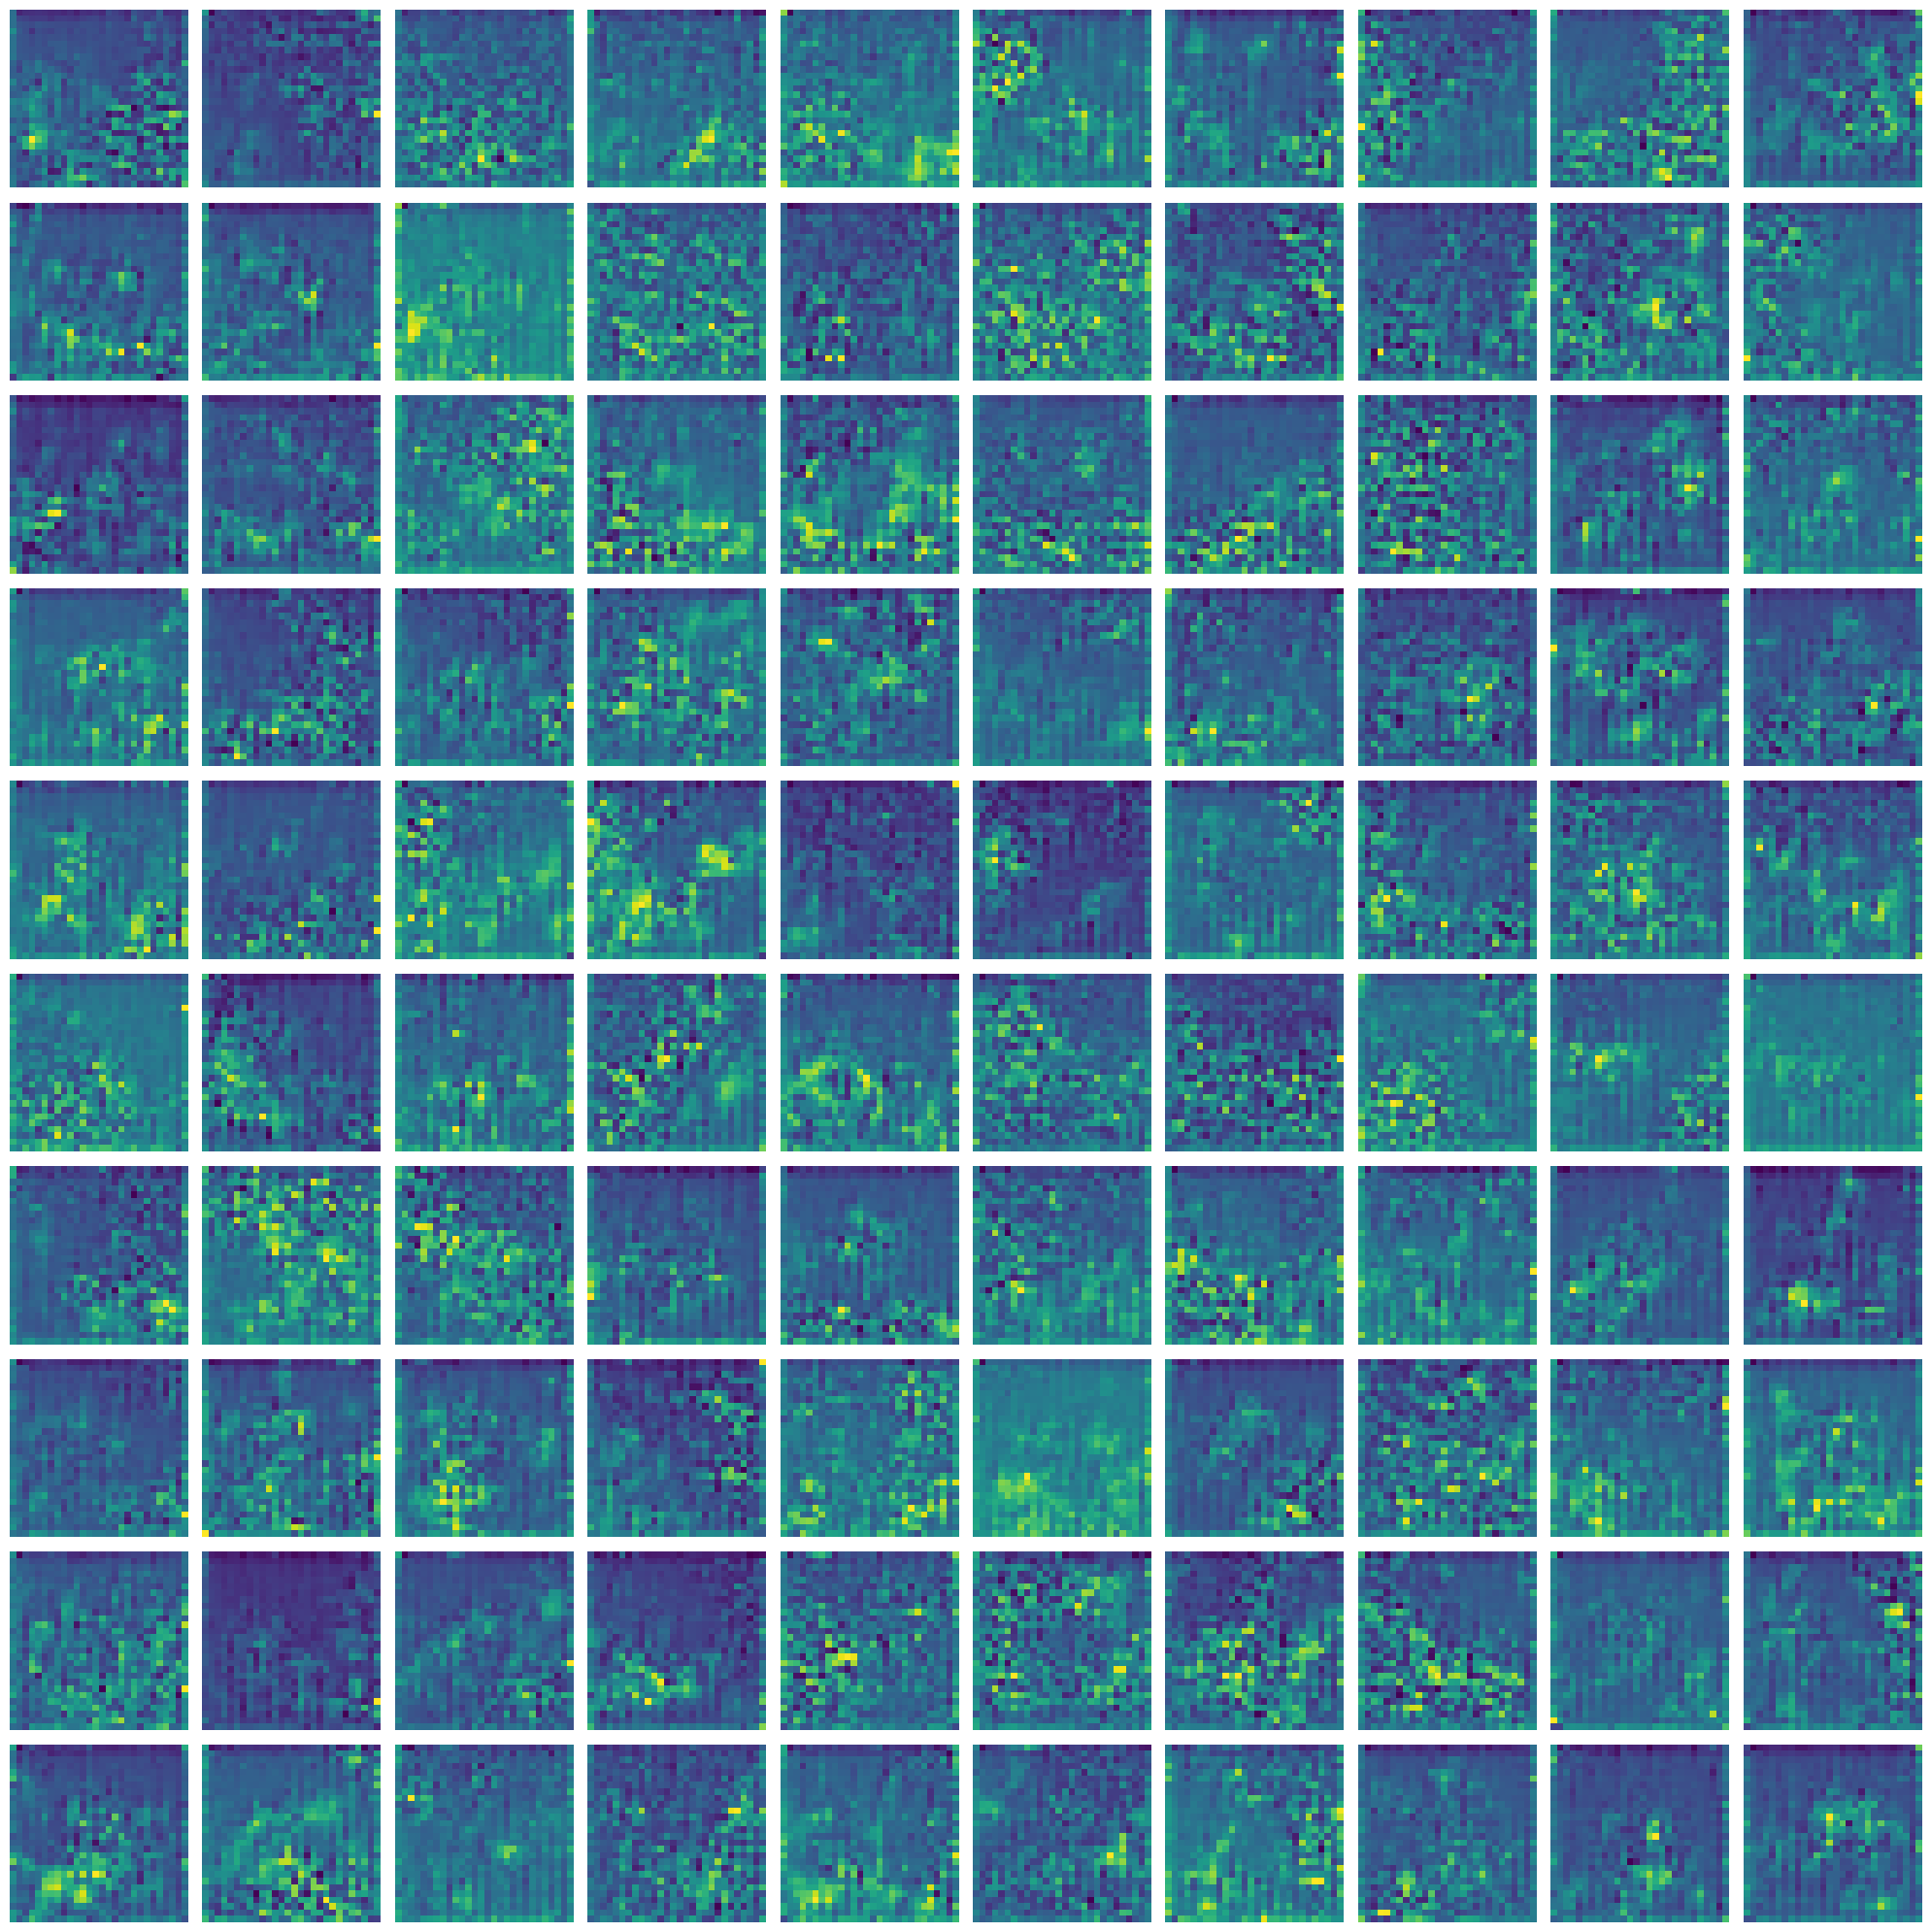

In [56]:
plot_image_grid(samples.squeeze(1).to('cpu').detach().numpy())